In [344]:
from sklearn.cluster import KMeans
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

## Data Loading

In [345]:
biomass_density = pd.read_csv('preprocessed/forecasted.csv')

In [346]:
distance_matrix = pd.read_csv('dataset/Distance_Matrix.csv')

In [347]:
distance_matrix = distance_matrix.drop('Unnamed: 0',axis=1)

In [348]:
biomass_density = biomass_density.drop('Unnamed: 0',axis=1)

In [349]:
distance_matrix.shape

(2418, 2418)

## Prprocessing

In [350]:
#new_distance = lambda den,dist: den/dist

In [351]:
biomass_density.head()

,Latitude,Longitude,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,24.66818,71.33144,0.212466,0.225726,0.219358,0.169677,0.231301,0.205046,0.243113,0.180307,0.199934,0.502740
1,24.66818,71.41106,0.300711,0.333306,0.309579,0.259861,0.340509,0.328613,0.428428,0.362593,0.334189,0.518164
2,24.66818,71.49069,0.370192,0.440955,0.402816,0.350319,0.433291,0.380620,0.486443,0.435923,0.397611,0.511109
3,24.66818,71.57031,0.407901,0.471496,0.449079,0.371401,0.475138,0.449872,0.525324,0.485404,0.437328,0.541641
4,24.66818,71.64994,0.255002,0.292657,0.292995,0.243953,0.281919,0.291840,0.317984,0.309058,0.257460,0.509233


In [352]:
distance_matrix.head()

,0,1,2,3,4,5,6,7,8,9,...,2408,2409,2410,2411,2412,2413,2414,2415,2416,2417
0,0.0000,11.3769,20.4557,38.1227,45.3810,54.9915,78.6108,118.6750,102.6639,113.4309,...,683.8771,687.6310,697.3246,669.3962,667.6788,665.5775,662.0291,665.9655,673.2073,681.4235
1,11.3769,0.0000,9.0788,28.9141,36.1724,45.7829,69.4022,78.2329,93.4553,111.1832,...,681.6295,685.3833,695.0769,667.1485,665.4311,663.3298,659.7815,663.7178,670.9596,679.1758
2,20.4557,9.0788,0.0000,22.3791,29.6374,39.2478,62.8671,71.6979,86.9203,111.7859,...,682.2323,685.9861,695.6796,667.7513,666.0339,663.9326,660.3843,664.3206,671.5623,679.7786
3,38.1227,28.9141,22.3791,0.0000,11.8343,23.5413,41.8396,50.6703,65.8927,82.5852,...,681.4226,685.1765,694.8701,666.9417,665.2243,663.1230,659.5746,663.5110,670.7528,678.9690
4,45.3810,36.1724,29.6374,11.8343,0.0000,11.7070,24.3986,33.2293,53.9901,65.1442,...,663.9816,667.7355,677.4291,649.5007,647.7833,645.6820,642.1336,646.0700,653.3118,661.5280


## Modelling

### Get initial point with most density of biomass

In [353]:
def get_most(column_name):
    density=biomass_density[column_name]
    return np.argmax(density)
    

### Get pobability based on biomass density

In [354]:
k=7

In [355]:
def set_prob(density):
    sum_density=sum(density)
    prob=[x/sum_density for x in density]
    return prob

In [356]:
weights=set_prob(biomass_density['2018'])

In [357]:
def get_depots(k,column_name,weights):
    depots=[]
    while len(depots)!=k :
        depots = np.random.choice(biomass_density[column_name].shape[0],size=k,p=weights)
    return depots

In [358]:
biomass_density['2018'].shape[0]

2418

In [359]:
depots = get_depots(k,'2018',weights)

### Visualising Data

In [360]:
def plot_depots(depots,clusters=None):
    depots_location = biomass_density.loc[depots, ["Latitude", "Longitude"]]

    print(depots_location)
    latitudes = biomass_density["Latitude"]
    longitudes = biomass_density["Longitude"]

    # Create a scatter plot
    plt.scatter(latitudes, longitudes,c=clusters)
    plt.scatter(depots_location["Latitude"], depots_location["Longitude"], marker='x', color='red')

    # Add a title and labels
    plt.title('Latitude and Longitude')
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')

    # Show the plot
    plt.show()

      Latitude  Longitude
2204  21.04116   70.61481
1974  21.44416   71.17219
1124  22.65317   73.24244
2264  20.96056   73.16282
2103  21.28296   73.48132
375   23.62038   71.41106
846   22.97557   69.34081


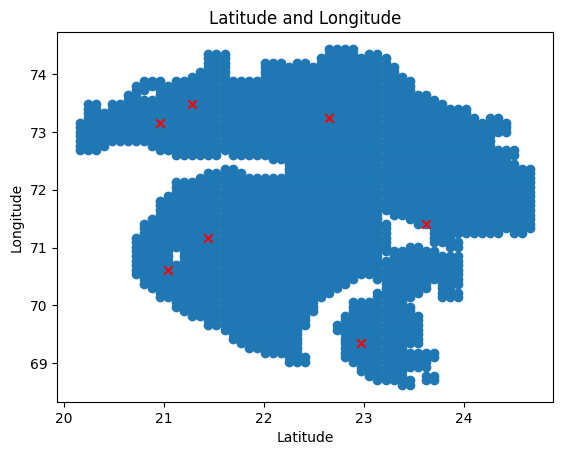

In [361]:
plot_depots(depots)

## Optimal clusters

In [362]:
from sklearn.cluster import KMeans 

In [363]:
def re_cluster(k,X,depots):
    belonging_to_cluster=np.array([])
    for i in range(X.shape[0]):
        distance=[distance_matrix.iloc[i,x] for x in depots]
        belonging_to_cluster=np.append(belonging_to_cluster,np.argmin(distance))

    depots = []
    for i in range(k):
        pseudo_coord = np.mean(X[belonging_to_cluster==i][['Latitude','Longitude']].to_numpy(),axis=0)
        distance = [np.linalg.norm(pseudo_coord - x) for x in X[belonging_to_cluster==i][['Latitude','Longitude']].to_numpy()]
        depots.append(X[belonging_to_cluster==i].iloc[np.argmin(distance),:].name)
        
    return depots,belonging_to_cluster

In [364]:
count=0
clusters=[]
for _ in range(30):
    prev=depots
    depots,clusters=re_cluster(k,biomass_density,depots)
    if np.array_equal(prev,depots):
        break
    print(depots)
    count+=1
print(f"Convergence in : {count} iterations")

[1794, 1645, 952, 2320, 1944, 293, 646]
[1739, 1587, 952, 2321, 1834, 255, 647]
[1739, 1587, 890, 2321, 1779, 256, 648]
[1739, 1646, 890, 2321, 1723, 256, 649]
[1685, 1702, 890, 2296, 1723, 256, 650]
[1685, 1702, 890, 2296, 1668, 256, 651]
[1685, 1702, 890, 2265, 1609, 257, 651]
Convergence in : 7 iterations


      Latitude  Longitude
1685  21.84717   70.05744
1702  21.84717   71.41106
890   22.97557   73.24244
2265  20.96056   73.24244
1609  22.00837   73.40169
257   23.86218   71.96844
651   23.21737   69.89819


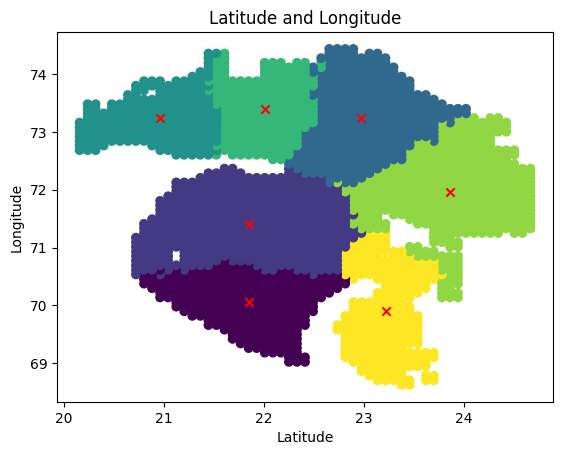

In [365]:
plot_depots(depots,clusters)

## Finding refineries